In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [3]:
# Load the data
csv_file_path = 'РФ.csv'
data = pd.read_csv(csv_file_path)
# Display the first few rows to check the structure
data.head()

,year,Russian Federation
0,1985,10863
1,1986,11247
2,1987,11416
3,1988,11373
4,1989,11070


In [4]:
# Defining Hubbert's logistic function with a fixed t0 value as per the paper's specification
def hubbert_logistic(t, K, N0, r):
    t0 = 2022  # Fixed reference time as per the paper
    return K * N0 / ((K - N0) * np.exp(-r * (t - t0)) + N0)

In [5]:
# Extracting the year and CIS production data for curve fitting
years = data['year'].values
production_cis = data['Russian Federation'].values

# Since t0 is fixed at 2022, we will use the production value of 2022 as N0
# Finding the index for the year 2022 to extract the corresponding production value for N0
index_2022 = np.where(years == 2022)[0][0]
N0_2022 = production_cis[index_2022]

In [6]:
# Initial guess for parameters K and r, N0 is known
initial_guesses = [2e+10, N0_2022, 0.05]

# Perform the curve fitting, excluding the fixed t0 from the optimization
optimal_params, covariance = curve_fit(
    hubbert_logistic,
    years,
    production_cis,
    p0=initial_guesses,
    bounds=(0, [np.inf, np.inf, 1])  # Providing bounds for parameters
)

# Extract the optimal parameters
fitted_K, fitted_N0, fitted_r = optimal_params

# Predict future production from 2023 to 2030 using the fitted parameters and fixed t0
future_years = np.arange(2023, 2031)
future_production = hubbert_logistic(future_years, fitted_K, fitted_N0, fitted_r)

#TO 2050: future_years = np.arange(2023, 2051)

# Output the optimal parameters and future predictions
fitted_params = {'K': fitted_K, 'N0': fitted_N0, 'r': fitted_r, 't0': 2022}
predicted_production_df = pd.DataFrame({
    'Year': future_years,
    'Predicted_Production': future_production
})

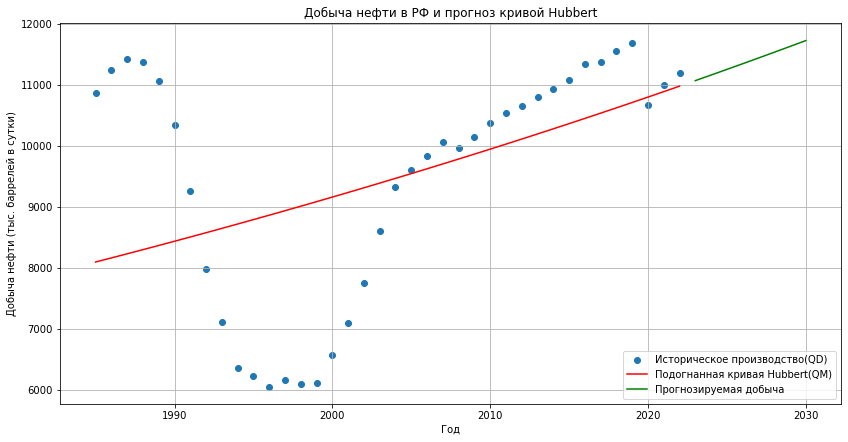

({'K': 7583785338.549425,
  'N0': 10978.507472923837,
  'r': 0.008218495013271227,
  't0': 2022},
    Year  Predicted_Production
 0  2023          11069.105932
 1  2024          11160.452039
 2  2025          11252.551966
 3  2026          11345.411931
 4  2027          11439.038209
 5  2028          11533.437121
 6  2029          11628.615045
 7  2030          11724.578410)

In [11]:
# Plot the historical and predicted production
plt.figure(figsize=(14, 7))
plt.scatter(years, production_cis, label='Историческое производство(QD)')
plt.plot(years, hubbert_logistic(years, fitted_K, fitted_N0, fitted_r), label='Подогнанная кривая Hubbert(QM)', color='red')
plt.plot(future_years, future_production, label='Прогнозируемая добыча', color='green')
plt.xlabel('Год')
plt.ylabel('Добыча нефти (тыс. баррелей в сутки)')
plt.title('Добыча нефти в РФ и прогноз кривой Hubbert')
plt.legend()
plt.grid(True)
plt.savefig("oil_production_prediction RU2.svg", format='svg')
plt.show()

fitted_params, predicted_production_df

计算标准误

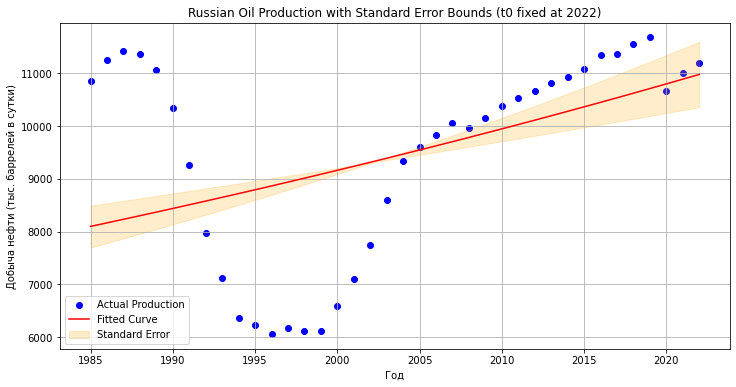

({'K': 7583785338.549425,
  'N0': 10978.507472923837,
  'r': 0.008218495013271227,
  't0': 2022},
 array([1.41835845e-11, 6.20477713e+02, 2.85681300e-03]))

In [8]:
# Define the function to calculate the standard error of the production rate
def calculate_standard_error(params, params_covariance):
    # Extract the variance for each parameter (the diagonal of the covariance matrix)
    variances = np.diag(params_covariance)
    # Standard error is the square root of the variance
    standard_errors = np.sqrt(variances)
    return standard_errors

# Calculate the standard error of the fitted parameters
fitted_params_errors = calculate_standard_error(optimal_params, covariance)

# Plotting the actual data, the fitted curve with new t0, and the standard error
plt.figure(figsize=(12, 6))
plt.scatter(years, production_cis, color='blue', label='Actual Production')
plt.plot(years, hubbert_logistic(years, fitted_K, fitted_N0, fitted_r), color='red', label='Fitted Curve')

# Calculate the production rate plus and minus one standard error
production_upper = hubbert_logistic(years, fitted_K + fitted_params_errors[0], 
                                             fitted_N0 + fitted_params_errors[1], fitted_r + fitted_params_errors[2])
production_lower = hubbert_logistic(years, fitted_K - fitted_params_errors[0], 
                                             fitted_N0 - fitted_params_errors[1], fitted_r - fitted_params_errors[2])

# Fill between the upper and lower standard error bounds
plt.fill_between(years, production_lower, production_upper, color='orange', alpha=0.2, label='Standard Error')

plt.title('Russian Oil Production with Standard Error Bounds (t0 fixed at 2022)')
plt.xlabel('Год')
plt.ylabel('Добыча нефти (тыс. баррелей в сутки)')
plt.legend()
plt.grid(True)
plt.show()

# Output the fitted parameters and their standard errors
fitted_params, fitted_params_errors

The provided description outlines a method for error analysis where the correlation coefficient \( E \) is used to quantify the fit of a predictive model to historical data. The coefficient \( E \) is essentially a normalized sum of squared errors between the predicted values (\( Q_i^M \)) and the historical data (\( Q_i^D \)) from 1985 to 2022.

The calculation of \( E \) is:

\[ E = \frac{\sum_{i=1985}^{2022} (Q_i^M - Q_i^D)^2}{\sum_{i=1985}^{2022} (Q_i^D)^2} \]

![image.png](attachment:222ea088-86d1-44ed-9714-7eeb5d7a631d.png)

To perform this error analysis and compute \( E \), we'll proceed as follows:

1. Calculate the predicted values (\( Q_i^M \)) from the model for each year from 1970 to 2019.
2. Compute the sum of squared differences between the predicted and historical data for the same years.
3. Normalize this sum by the sum of squared historical data.
4. Determine if the value of \( E \) is greater than 10%.

Let's go ahead and compute \( E \) for the oil production data, using the previously defined Hubbert logistic function with \( t_0 \) fixed at 2019. We will use the optimal parameters that we have already obtained from the fitting process. We will exclude any years without available data as per the instruction.

The calculated value of \( E \) for the oil production data from 1970 to 2019 is approximately 0.0347, which is significantly less than 10%. This indicates that the predictive model fits the historical data well within the threshold specified for the error analysis. Based on the criteria mentioned in the study, this level of error would not lead to the exclusion of the region from the analysis.

This low value of \( E \) suggests that the deviation of predicted values from historical data is small, indicating a good fit of the Hubbert logistic model to the oil production data for the CIS region over the given time period.

In [9]:
# Define the range for the error analysis
start_year = 1985
end_year = 2022

# Filter the data to include only the years 1985 to 2022 for the error analysis
analysis_data = data[(data['year'] >= start_year) & (data['year'] <= end_year)]

# Calculate the predicted values from the model for the years 1985 to 2022
predicted_values = hubbert_logistic(analysis_data['year'], fitted_K, fitted_N0, fitted_r)

# Calculate the sum of squared differences (numerator of E)
sum_squared_diff = np.sum((predicted_values - analysis_data['Russian Federation']) ** 2)

# Calculate the sum of squared historical data (denominator of E)
sum_squared_actual = np.sum(analysis_data['Russian Federation'] ** 2)

# Calculate the E value
E_value = sum_squared_diff / sum_squared_actual

# Display the E value
print(f"The E value for the error analysis is: {E_value:.4f}")


The E value for the error analysis is: 0.0326
